In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from samwich.dataloaders import RawData
from samwich.waketrackers import track, Plotter

In [3]:
from examples.turbines import Turbine  # container for turbine properties
from examples.defaults import styles

# Comparison of Different Wake Tracking Methods
Written by [Eliot Quon](mailto:eliot.quon@nrel.gov) -- 2017-01-04

This is the basis for one of the regression tests

In [4]:
trackerlist = track()

Need to specify 'method' as one of:
  Gaussian (samwich.gaussian.GaussianTracker)
  Gaussian2D (samwich.gaussian.Gaussian2DTracker)
  ConstantFlux (samwich.contour.ConstantFluxTracker)
  ConstantArea (samwich.contour.ConstantAreaTracker)
  CircularTestRegion (samwich.testregion.CircularTestRegionTracker)


## Setup

In [5]:
turb = Turbine('V27')
print(turb)

V27
---
hub height: 32.1 m
diameter: 27 m
ref area: 572.555 m^2
ref CP: 0.588
ref CT: 0.84


In [6]:
turb.base_location = (2414.8, 1633.3)

In [7]:
datadir = os.path.join(os.environ['HOME'],'waketracking','reg_tests','MWE-data')
datadir

'/Users/equon/waketracking/reg_tests/MWE-data'

## Read in test data
Note: General dataloaders exist to handle processing of multiple sampling locations and/or many samples over time.

In [8]:
sample = RawData(os.path.join(datadir,'snapshot_instantaneous_WFoR.csv'))

In [9]:
x,y,z,u = sample.sliceI()

Slicing data at i=0 x=2495.8


See `example_02_inflow_setup`:

In [10]:
profile = np.loadtxt(os.path.join(datadir,'wind_profile.csv'), delimiter=',')

In [11]:
Uref = np.interp(turb.zhub, profile[:,0], profile[:,1])
Uref

6.837746550647215

## Calculate additional tracking parameters

In [12]:
xloc = (np.mean(x) - turb.base_location[0])
xloc/turb.D

3.0

In [13]:
ref_thrust = turb.ref_CT * 0.5*Uref**2 * turb.rotor_area  # force / density
print('ref thrust (momentum deficit) is',ref_thrust,'N/(kg/m^3)')

ref thrust (momentum deficit) is 11243.271506784444 N/(kg/m^3)


## Perform wake identification

In [14]:
# create a plotter object and add each wake tracking instance to it
wp = Plotter()

### - Constant area contours

In [15]:
tracker = 'const area'
wake = track(x,y,z,u, method='ConstantArea', verbose=True) 
wake.remove_shear(wind_profile=profile)
yc,zc = wake.find_centers(turb.rotor_area)
wp.add(tracker, wake, **styles[tracker])
# workaround for %matplotlib inline (first time Plotter.add() is called, an empty figure will be initialized)
plt.close()

Selected Tracker: ConstantArea

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 2495.8 1633.2849999999999 43.300985499999996
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -58.96499999999992 58.965000000000146
  vertical search range: 0.619571 85.9824
Number of time frames to process: 1

...finished initializing WakeTracker

...finished initializing ContourWakeTracker

...finished initializing ConstantArea 

  subtracting out profile (constant in time)
Attempting to match area: 572.5552611167398 m^2


Processed frame 0


### - Momentum deficit contours
Recall: definition of velocity components in SAMWICH Box $u_{tot} = u_{avg} + u$


momentum flux $M = U_w(U_\infty - U_w) = -(U_w - U_\infty)U_w = $ `-u*u_tot`, for wake velocity $U_w$

In [16]:
tracker = 'const momentum deficit'
flux = lambda u,u_w: -u * u_w  # function arguments correspond to field_names
wake = track(x,y,z,u, method='ConstantFlux', verbose=True) 
wake.remove_shear(wind_profile=profile)
yc,zc = wake.find_centers(ref_thrust,
                          flux_function=flux,
                          field_names=('u','u_tot'))
wp.add(tracker, wake, **styles[tracker])

Selected Tracker: ConstantFlux

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 2495.8 1633.2849999999999 43.300985499999996
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -58.96499999999992 58.965000000000146
  vertical search range: 0.619571 85.9824
Number of time frames to process: 1

...finished initializing WakeTracker

...finished initializing ContourWakeTracker

...finished initializing ConstantFlux 

  subtracting out profile (constant in time)
Sample function evaluation: f(u=-4.860218848167541,u_tot=0.38453) = 1.8688999536858646
Attempting to match flux: 11243.271506784444


Processed frame 0


### - Gaussian Fits

In [17]:
tracker = '1-D Gaussian'
wake = track(x,y,z,u, method='Gaussian',verbose=True) 
wake.remove_shear(wind_profile=profile)
yc,zc = wake.find_centers(umin=None,  # default: detected from wake snapshot
                          sigma=turb.D/2)
wp.add(tracker, wake, **styles[tracker])

Selected Tracker: Gaussian

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 2495.8 1633.2849999999999 43.300985499999996
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -58.96499999999992 58.965000000000146
  vertical search range: 0.619571 85.9824
Number of time frames to process: 1

...finished initializing WakeTracker

...finished initializing Gaussian 

  subtracting out profile (constant in time)
Calculated umin= [-4.86021885]
Average Gaussian function amplitude = -4.860218848167541 m/s (over 1 times)
Specified Gaussian width = 13.5 m
Reference Gaussian area = 572.5552611167398 m^2


Processed frame 0


Estimated from momentum deficit...

In [18]:
tracker = '1-D Gaussian (ideal sigma)' # sigma estimated from momentum deficit
wake = track(x,y,z,u, method='Gaussian',verbose=True) 
wake.remove_shear(wind_profile=profile)

max_VD = -np.min(wake.u,axis=(1,2))  # max velocity deficit, u.shape == (Ntimes,Nh,Nv)
sigma_opt = np.sqrt(ref_thrust / (np.pi*max_VD*(2*Uref - max_VD)))

yc,zc = wake.find_centers(umin=None,  # default: detected from wake snapshot
                          sigma=sigma_opt)
wp.add(tracker, wake, **styles[tracker])

Selected Tracker: Gaussian

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 2495.8 1633.2849999999999 43.300985499999996
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -58.96499999999992 58.965000000000146
  vertical search range: 0.619571 85.9824
Number of time frames to process: 1

...finished initializing WakeTracker

...finished initializing Gaussian 

  subtracting out profile (constant in time)
Calculated umin= [-4.86021885]
Average Gaussian function amplitude = -4.860218848167541 m/s (over 1 times)
Mean/min/max reference Gaussian area: 262.4224856265574 262.4224856265574 262.4224856265574 m^2


Processed frame 0


The Bastankhah & Porte-Agel gaussian model accounts for wake growth ($k^*$), which may be calculated from turbulence intensity (TI)

In [19]:
tracker = '1-D Gaussian (Bastankhah)'
from samwich.gaussian_functions import Bastankhah
gauss = Bastankhah(CT=turb.ref_CT, d0=turb.D, kstar=0.03) # ad-hoc value from Bastankhah & Porte-Agel 2014
#gauss = Bastankhah(CT=turb.ref_CT, d0=turb.D, TI=0.20)

wake = track(x,y,z,u, method='Gaussian',verbose=True) 
wake.remove_shear(wind_profile=profile)
yc,zc = wake.find_centers(umin=gauss.amplitude(xloc,-Uref),
                          sigma=gauss.sigma(xloc))
wp.add(tracker, wake, **styles[tracker])

Selected Tracker: Gaussian

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 2495.8 1633.2849999999999 43.300985499999996
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -58.96499999999992 58.965000000000146
  vertical search range: 0.619571 85.9824
Number of time frames to process: 1

...finished initializing WakeTracker

...finished initializing Gaussian 

  subtracting out profile (constant in time)
Calculated Gaussian width : 9.573528539874394 m
Calculated Gaussian amplitude : -4.061637468341464 m/s
Calculated Gaussian width : 9.573528539874394 m
Average Gaussian function amplitude = -4.061637468341464 m/s (over 1 times)
Specified Gaussian width = 9.573528539874394 m
Reference Gaussian area = 287.93465953134057 m^2


Processed frame 0


### - 2D Gaussian

In [20]:
tracker = '2-D Gaussian'
wake = track(x,y,z,u, method='Gaussian2D',verbose=True) 
wake.remove_shear(wind_profile=profile)
yc,zc = wake.find_centers(umin=None,  # default: detected from wake snapshot
                          A_ref=turb.rotor_area,
                          A_min=turb.rotor_area/5,  # ad hoc value
                          A_max=turb.rotor_area*2,  # ad hoc value
                          AR_max=10.0,  # ad hoc value
                          verbosity=1,  # > 0 for debugging
                         )
wp.add(tracker, wake, **styles[tracker])

Selected Tracker: Gaussian2D

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 2495.8 1633.2849999999999 43.300985499999996
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -58.96499999999992 58.965000000000146
  vertical search range: 0.619571 85.9824
Number of time frames to process: 1

...finished initializing WakeTracker

...finished initializing Gaussian2D 

  subtracting out profile (constant in time)
average Gaussian function amplitude = -4.860218848167541 m/s (over 1 times)

itime = 0
-------------
1D-Gaussian guess: [-17.57028198  35.67103972]
Selected best of [1359.1058172545536]
yc,zc : -20.6, 39.0; rotation=-8.971427131686353 deg; ref wake area=279.67367527674617 m^2 (outline level=-0.6577590944086777)


Processed frame 0


### - Test Region

In [21]:
tracker = 'min power'
wake = track(x,y,z,u, method='CircularTestRegion',verbose=True) 
wake.remove_shear(wind_profile=profile)
yc,zc = wake.find_centers(test_radius=turb.D/2,  # following Vollmer 2016
                          test_function=lambda u: u**3,
                          test_field='u_tot')
wp.add(tracker, wake, **styles[tracker])

Selected Tracker: CircularTestRegion

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 2495.8 1633.2849999999999 43.300985499999996
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -58.96499999999992 58.965000000000146
  vertical search range: 0.619571 85.9824
Number of time frames to process: 1

...finished initializing WakeTracker

...finished initializing CircularTestRegion 

  subtracting out profile (constant in time)
Searching within a region with radius=13.5


Processed frame 0


## Comparisons

const area -20.417699417461968 38.002870910754346
const momentum deficit -16.89433868318505 36.32497160489447
1-D Gaussian -17.5702819777506 35.67103971533528
1-D Gaussian (ideal sigma) -19.754208281998373 38.22483831275326
1-D Gaussian (Bastankhah) -19.427571792103322 37.9723295442911
2-D Gaussian -20.62177805723672 38.991757596179774
min power -20.392734433817406 37.0712545509066


Plot: frame 0

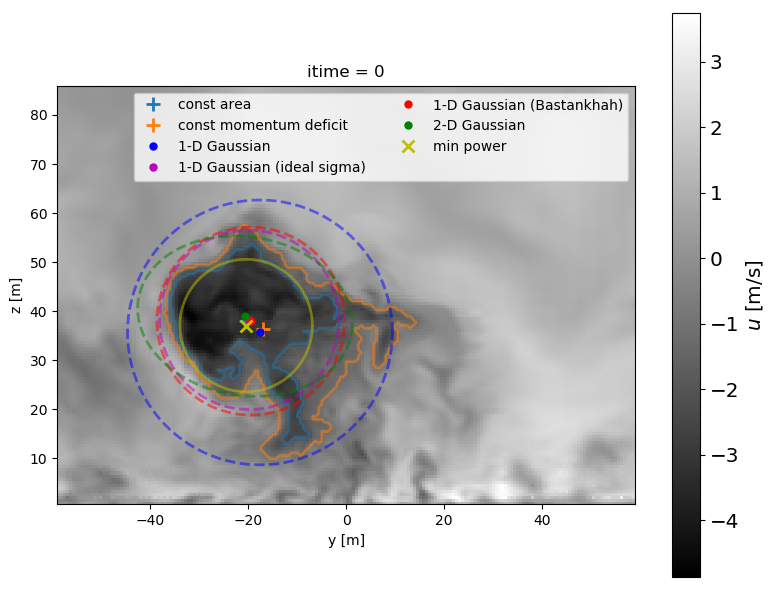

In [22]:
wp.plot(verbose=True)
wp.legend(ncol=2)
wp.savefig('allwakes.png',dpi=150)
wp.fig  # because the figure object was previously created and hidden, this is how we bring it back

### - gaussian fitting methods

Plot: frame 0

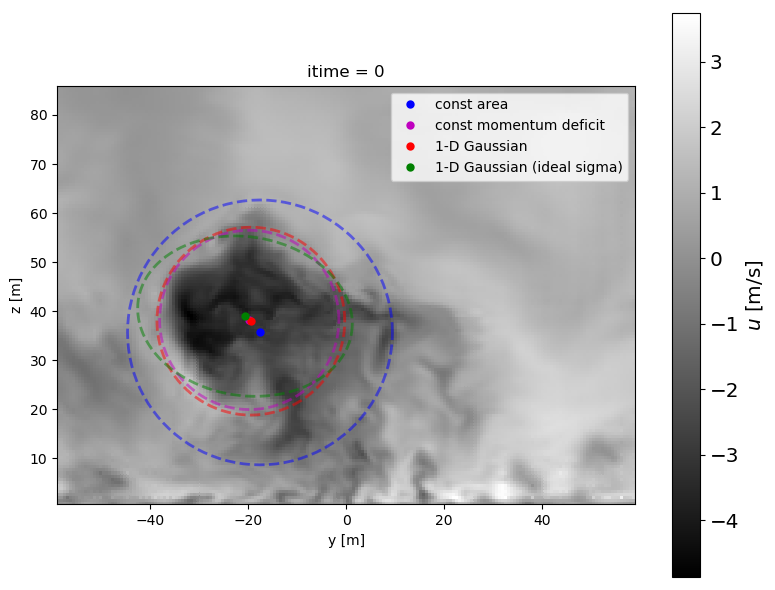

In [23]:
wp.plot(wakes=['1-D Gaussian','1-D Gaussian (Bastankhah)','1-D Gaussian (ideal sigma)','2-D Gaussian'])
wp.legend()
wp.savefig('gaussianwakes.png',dpi=150)
wp.fig

### - contour methods

Plot: frame 0

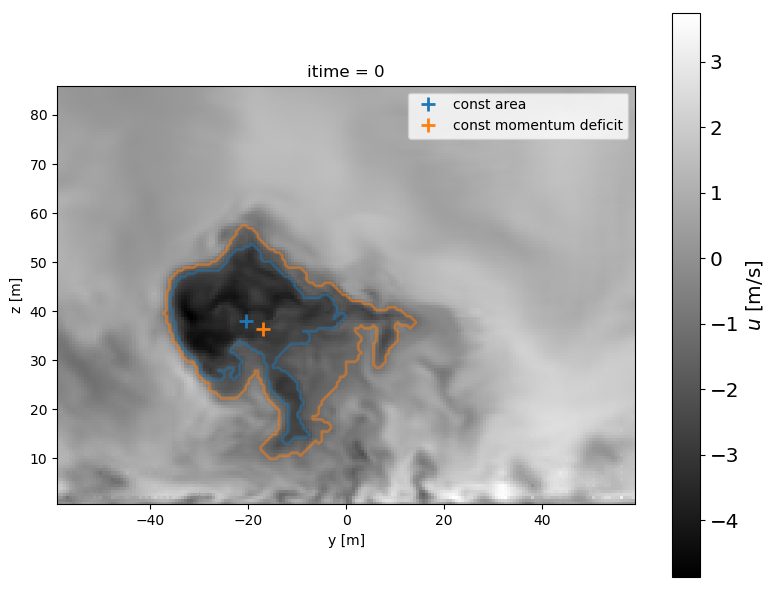

In [24]:
wp.plot(wakes=['const area','const momentum deficit'])
wp.legend()
wp.savefig('contourwakes.png',dpi=150)
wp.fig